In [130]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul  3 11:41:59 2015

@author: suberlak

A program to read-in a sample of QSO, Stars red, Stars blue, 
selected from my master files according to  SDSS_r < 20 ,  
CRTS_err < 0.3  ,  and log10(tau) < 1.7 . 

Note that SDSS_r is the SDSS_r magnitude, and 

Further, I cut QSO     -1.5 < delflux < 1.5 , and 
              stars    -1.0 < delflux < 1.0 
             a 
Here, I perform three steps: 

1) For stars, assume mu=0, and given err_f, fit SF
2) For stars, assume mu=0, SF=0, and fit err_f as a free parameter 
3) Keep that err_f, and fit Quasars with SF

The program inherits many functions from sf_sample.py, 
but lacks all the ability to calculate SF and mu from 
the probability distribution, which in this 
approach is not needed. 
              
"""

import numpy as np 
import matplotlib.pyplot as plt 
from astroML.plotting import scatter_contour 
from scipy.stats import binned_statistic
import seaborn as sns 
sns.set_context("poster")
from scipy.optimize import curve_fit
%matplotlib inline


# READ IN THE FILES  
def read_file(obj):
    '''
    By default, want to use SDSS_r filter data. However, accidentally 
    I saved SDSS_g filter data for Stars for Sample_4  . Sample_4 for QSO has 
    SDSS_r mags.   So  I made a Sample_6 , with identical criteria (hence 
    the same number of lines), but storing SDSS_r mag instead.  Thus, if need
    be,  for stars I can plot delflx / delflxerr vs SDSS_r or SDSS_g 
    
    '''


    if obj == 'StarB_g' : 
        File = 'Sample_4_Stars_blue_314248_lines.txt'
    if obj == 'StarB':
        File = 'Sample_6_Stars_blue_314248_lines.txt'
        
    if obj == 'StarR_g' :
        File = 'Sample_4_Stars_red_373306_lines.txt'
    if obj == 'StarR':
        File = 'Sample_6_Stars_red_373306_lines.txt'
        
    if obj == 'QSO' :
        File = 'Sample_6_QSO_721283_lines.txt'
        
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    data = {}
    print 'Zipping ', obj, ' data from ', File, ' ...'
    for label, column in zip(colnames, datatable.T):
        data[label] = column

    return data

# DEFINE GAUSSIAN TO BE CONVOLVED 
def gaussian(x,mu,sigma):
    exponent = -(x-mu)**2.0 / (2.0 * (sigma ** 2.0))
    f = (1.0 / (np.sqrt(2.0*np.pi)*sigma)) * np.exp(exponent)    
    return f


def get_histogram(xdata, nbins):
    """ Calculate simple histogram given the 1D data array, and number of bins. 
    
    It first calculates unnormalized histogram (because numpy normalization 
    works in  a way so that the integral over all space=1 , which is not what
    I want). Then it divides it by the number of elements in the input data array,
    and the bin width. 
    In case a normalisation was needed, I calculate the area under the histogram,
    to scale up the gaussian by the area. 
    In case a normalised gaussian was needed, I also calculate it, but bins 
    are the same as for not-normalised gaussian . 
    """
    
    N_hist_ttl = float(len(xdata))
    hist, bin_edges = np.histogram(xdata, bins=nbins, density=False) 
    bin_cen = (bin_edges[:-1] + bin_edges[1:])/2 
    bin_width = (bin_edges[-1] - bin_edges[0]) / float(nbins)
    bin_width = bin_edges[1]-bin_edges[0]
    hist  = hist / (N_hist_ttl * bin_width)
    area = np.sum(bin_width * hist)
    
    print 'N_hist_ttl=', N_hist_ttl
    print 'Delta_bin = ', bin_width
    
    
    # Calculate normalised histogram, so that the INTEGRAL under the curve=1
    # This allows me to overplot the Gaussian too! 
    hist_n, edges = np.histogram(xdata, bins=nbins, density=True)
    return hist, hist_n, bin_cen, area 


def combine_gaussians(xi, ei, hist_xlim, sigma, mu,  err_f=1.0 ):
    """ A function to convolve gaussians according to chosen model
    
    Returns:
    xgrid, which is the grid of delta_mag on which histogram was 
           evaluated 
    model, which is the combined gaussians model 
    """
    
    xgrid = xi
    
    N = float(len(xi))
           
    
    model = np.zeros_like(xgrid)
    for i in range(len(xi)):
        sig_com = np.sqrt(sigma ** 2.0 + (err_f*ei[i])**2.0)
        Gi =  gaussian(xgrid,mu, sig_com)
        model += Gi  
    model= (1.0 / N) * model
    
    return model
    
    
    
def load_xi_ei(data_dict, mag_min, mag_max):
    """ Load delflx, delflxerr from sample files (star or QSO)
    
    It assumes that the data dictionary has fields delflx, delflxerr,
    SDSS_r_mMed. So it'll not work if we use SDSS_g_mMed, or anything else...
    """
    
    mask = (data_dict['SDSS_r_mMed'] < mag_max) * (data_dict['SDSS_r_mMed'] >mag_min)
    delflx = data_dict['delflx'][mask]
    delflxerr = data_dict['delflxerr'][mask]
    return delflx, delflxerr
    
 


In [2]:
# Read in the data     
starB_rMag = read_file('StarB')

# What are the ranges of magnitude on each subplot 
# from mag_min[i] to mag_max[i]
mag_min = [17, 18, 18.5]
mag_max = [18, 18.5, 19]

# What are sigma (SF), mu, histogram limits (x-axis) for QSO and stars ? 
# they are different for QSO's and stars 

qso_sig = [0.0997, 0.10456, 0.15105]
qso_mu = [-0.00097, -0.00033, -0.00254]
starB_sig = [0.0607, 0.1015, 0.1303]
starB_mu = [0.0009, 0.00037, -0.002]
hist_qso = [-1.0,1.0]
hist_starB = [-1.0,1.0]

# Set the error factor for the plots ...
#err_inc = 0.72



Zipping  StarB  data from  Sample_6_Stars_blue_314248_lines.txt  ...


In [147]:

def fit_star_SF(data,mag_min, mag_max, sig, mu, hist_lim, i):
    
    
    
    # load the data del_mag, and del_mag_err 
    delflx, delflxerr = load_xi_ei(data, mag_min[i], mag_max[i])
    len_original = float(len(delflx))
    
    # put constraints on the data, same as on histogram 
    mask = (delflx < hist_lim[1] )*(delflx>hist_lim[0])
    delflx = delflx[mask]
    delflxerr = delflxerr[mask]
    
    # dialog 
    percent = (100.0*float(len(delflx))) / len_original
    print 'The hist limits criteria are satisfied by ', percent, ' percent'
    
    # calculate histogram values 
    hist, hist_n, bins, area = get_histogram(xdata=delflx, nbins=150)
    #return hist, bins , delflx, delflxerr
    
    # sort delflx and accordingly read delflxerr for interpolation
    ind = delflx.argsort()
    yerr = np.interp(bins, delflx[ind], delflxerr[ind])

    xdata = bins
    ydata = hist
    
    fig , axs = plt.subplots(1,1, figsize=(6,6))
    axs.plot(bins, hist,ls='steps', lw=2, label='data') 
    axs.set_xlabel(r'$\Delta m$')
    axs.set_ylabel(r'$n(bin) / (N \cdot \Delta (bin))$')
    
    # PROBLEM HERE  : I need to have some xdata and ydata, but if xdata are bins and ydata is hist, 
    # then I cannot pass delflxerr to combine_gaussians(), because it has completely different 
    # dimensions! I would have then to either evaluate histogram on as many points as len(delflxerr)
    # (unrealistic), or sample delflxerr at the same points as bins : more realistic ! 
    
    f_arr = np.linspace(0.7,1.5, 10)
    sig_arr = []
    for  f in f_arr :
        print 'We fix mu=0, and err_f=%f' %f
        popt, pcov = curve_fit(lambda xdata, sigma_fit: combine_gaussians(xi=xdata, ei=yerr, hist_xlim=hist_lim,
                                                                      sigma = sigma_fit, mu=0, err_f = f),
                                xdata, ydata)

        sigma_fit =  popt[0]
        print 'fitted SF=', sigma_fit, '\n'
        sig_arr.append(sigma_fit)
    
        model = combine_gaussians(xi=xdata, ei=yerr, 
                                     hist_xlim=hist_lim, sigma=sigma_fit, 
                                     mu=0, err_f=f )
    
    
        # Plot  the fitted model1
        #model1_lab = r'$ f_{c}=1.0$' # % (sig[i], mu[i])
        axs.plot(xdata, model, lw=2)
    
    return f_arr, sig_arr
        

The hist limits criteria are satisfied by  100.0  percent
N_hist_ttl= 66706.0
Delta_bin =  0.0132846666667
We fix mu=0, and err_f=0.700000
fitted SF= 0.00899215943348 

We fix mu=0, and err_f=0.788889
fitted SF= -2.77521443653e-07 

We fix mu=0, and err_f=0.877778
fitted SF= 5.74033274423e-08 

We fix mu=0, and err_f=0.966667
fitted SF= -2.75888992946e-07 

We fix mu=0, and err_f=1.055556
fitted SF= -6.11621337776e-07 

We fix mu=0, and err_f=1.144444
fitted SF= -1.76056163663e-06 

We fix mu=0, and err_f=1.233333
fitted SF= -1.5359010339e-06 

We fix mu=0, and err_f=1.322222
fitted SF= -2.09970199596e-06 

We fix mu=0, and err_f=1.411111
fitted SF= -2.66968018363e-07 

We fix mu=0, and err_f=1.500000
fitted SF= 8.75417658181e-08 



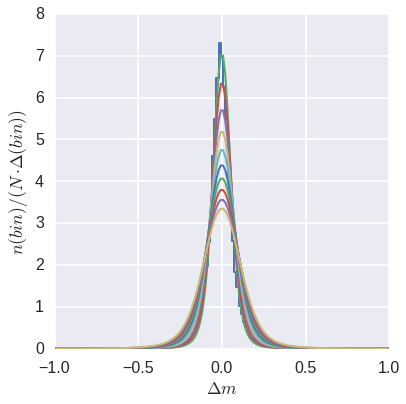

In [148]:
f_arr, sig_arr = fit_star_SF(data=starB_rMag,mag_min=mag_min, mag_max=mag_max, sig=starB_sig, mu=starB_mu, 
                         hist_lim =hist_starB)

# PROBLEM HERE : why does it seem that it is not really fitting? It looks like for certain values of err_f,  the fit 
# is great, but for some other values of err_f it is completely wrong, and it can be seen from the plot itself... 

# NEED TO WRITE ANOTHER FUNCTION TO ASSUME  SF=0 , and plot what is err_f   necessary for a good fit ?  

# HOW TO INTERPRET ZELJKO'S TABLE ? 

# MY FITS ABOVE ARE ONLY WORKING FOR THE FIRST BIN   (i=0) : 
# --> need to loop over i's... 

###   bin    SF(1.0)     SF(*corrected)  *corr     
###    1       0.000            0.045            0.72      
###    2       0.045            0.052            0.91     
###    3       0.089            0.070            1.07       
###    4       0.140            0.100            1.26  


In [108]:
# How to sort one array according to another array 
a = np.arange(10)[::-1]
b = np.arange(10) * 0.1
b = b[::-1]
c = np.array([a[::-1],b])
print 'a=',a
print 'b=',b
ind  = a.argsort()
print 'sorted a=',a[ind]
print 'sorted b=', b[ind]


a= [9 8 7 6 5 4 3 2 1 0]
b= [ 0.9  0.8  0.7  0.6  0.5  0.4  0.3  0.2  0.1  0. ]
sorted a= [0 1 2 3 4 5 6 7 8 9]
sorted b= [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]


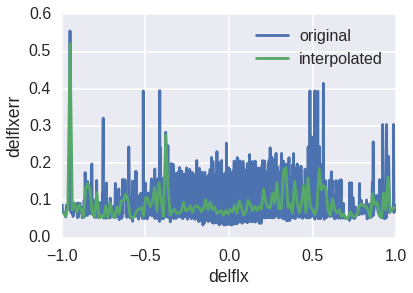

In [123]:
#plt.scatter(bins, err_sample)
ind = delflx.argsort()
delflx = delflx[ind]
delflxerr = delflxerr[ind]
#plt.scatter(np.arange(len(delflx)), delflx)  # shows that delflx is indeed sorted 
#plt.plot(np.arange(len(b[0][:100])), b[0][:100])
err_sample = np.interp(bins, delflx, delflxerr)

plt.plot(delflx, delflxerr, label='original')
plt.plot(bins,err_sample, label='interpolated')
plt.xlabel('delflx')
plt.ylabel('delflxerr')
plt.legend()

In [58]:
fit_star_SF(data=starB_rMag,mag_min=mag_min, mag_max=mag_max, sig=starB_sig, mu=starB_mu, hist_lim =hist_starB)

The hist limits criteria are satisfied by  100.0  percent
N_hist_ttl= 66706.0
Delta_bin =  0.0132846666667


ValueError: operands could not be broadcast together with shapes (2,10000) (150,) 

In [38]:
#http://stackoverflow.com/questions/12208634/fitting-only-one-paramter-of-a-function-with-many-parameters-in-python
# Fitting only one paramter of a function with many parameters in python 

def func(x, a, b, c, d ):
    #print d
    return a * np.exp(-b * x) + c


In [44]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5,'str')
ydata = y + 0.2 * np.random.normal(size=len(xdata))
d= 'string'
popt, pcov = curve_fit(lambda x, a,b,c: func(x,a,b,c,d) , xdata, ydata)



In [45]:
popt

array([ 2.54398813,  1.48968494,  0.53986881])

In [46]:
pcov

array([[ 0.0154819 ,  0.00770719, -0.00057296],
       [ 0.00770719,  0.02199879,  0.00472223],
       [-0.00057296,  0.00472223,  0.00219769]])

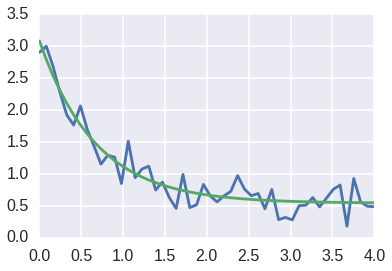

In [47]:
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata,popt[0], popt[1], popt[2],d))

